In [184]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, namedtuple
from dataclasses import dataclass

In [186]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [187]:
LAND = 'land'
AIR = 'air'
SEA = 'sea'
A = AIR
L = LAND
S = SEA

In [188]:
# Sensor = namedtuple('Sensor', ['name', 'domain', 'range'])

In [189]:
Unit = namedtuple('Unit', ['name', 'domain', 'range', 'sensors', 'weapons', 'cost'])

In [190]:
UNITS = [
    Unit('Cruiser', SEA, 2000, [(S, 50), (A, 200)], [(AIR, 100, 100), (S, 400, 20), (L, 400, 10)], 4000),
    Unit('Destroyer', SEA, 2000, [(S, 50), (A, 150)], [(AIR, 100, 32), (S, 300, 16), (L, 400, 5)], 2000),
    Unit('Frigate', SEA, 2000, [(S, 50), (A, 100)], [(AIR, 50, 32), (S, 200, 8), (L, 50, 5)], 1000),
    Unit('Bomber', AIR, 2000, [], [(S, 150, 10), (L, 150, 10), (S, 350, 3)], 300),
    Unit('Interceptor', AIR, 1000, [(AIR, 100)], [(AIR, 100, 8)], 120),
    Unit('Fighter', AIR, 450, [(AIR, 100), (S, 100)], [(AIR, 100, 4), (S, 100, 4), (L, 50, 4)], 100),
    Unit('MPA', AIR, 1200, [(S, 150)], [(S, 100, 6)], 300),
    Unit('Helicopter', AIR, 350, [(S, 50)], [(S, 10, 4), (L, 1, 1000)], 40),
    Unit('IRBM', LAND, 0, [], [(L, 1100, 4)], 40),
    Unit('Radar', LAND, 0, [(A, 300)], [], 500),
    Unit('Airbase', LAND, 0, [], [], 10000),
    Unit('Civilians', LAND, 0, [], [], 10000),  # represents 10k civilians @ 100k/civilian
    Unit('Small SAM', LAND, 0, [(A, 25)], [(A, 6, 8)], 25),
    Unit('Medium SAM', LAND, 0, [(A, 50)], [(A, 25, 36)], 120),
    Unit('Large SAM', LAND, 0, [(A, 150)], [(A, 100, 48)], 500),
    Unit('AShM Site', LAND, 0, [], [(S, 100, 8)], 50),
]
UNIT_LOOKUP = {}
for unit in UNITS:
    UNIT_LOOKUP[unit.name] = unit

In [191]:
terrain = np.zeros((20, 40))
terrain[:, :5] = 1
terrain[:, -1] = 1
terrain[8:11, 7:9] = 1
terrain[:1, 14:16] = 1
terrain[-1:, 25:27] = 1

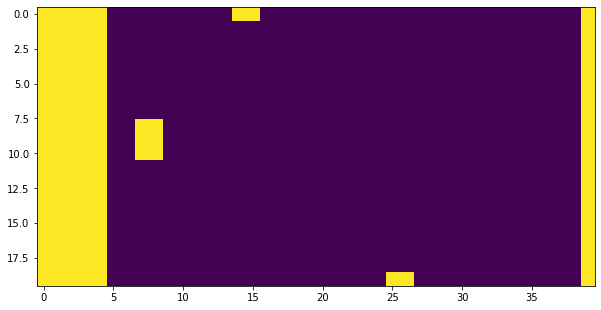

In [192]:
plt.imshow(terrain)

In [193]:
OOB = [
    (UNIT_LOOKUP['Airbase'], 4),
    (UNIT_LOOKUP['Cruiser'], 1),
    (UNIT_LOOKUP['Destroyer'], 5),
    (UNIT_LOOKUP['Frigate'], 5),
    (UNIT_LOOKUP['Bomber'], 16),
    (UNIT_LOOKUP['Interceptor'], 16),
    (UNIT_LOOKUP['Fighter'], 16),
    (UNIT_LOOKUP['MPA'], 16),
    (UNIT_LOOKUP['Helicopter'], 32),
    (UNIT_LOOKUP['IRBM'], 50),
    (UNIT_LOOKUP['Small SAM'], 25),
    (UNIT_LOOKUP['Medium SAM'], 10),
    (UNIT_LOOKUP['Large SAM'], 4),
    (UNIT_LOOKUP['AShM Site'], 4),
    (UNIT_LOOKUP['Radar'], 4),
]

In [194]:
def plot_locs(terrain, locs):
    loc_map = np.zeros_like(terrain)

    for loc in locs:
        loc_map[loc] = 0.5
    plt.imshow(loc_map + terrain)


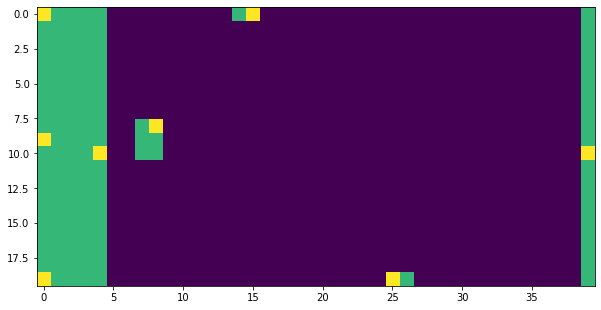

In [195]:
airbase_locs = [
    (0, 0),
    (19, 0),
    (9, 0),
    (10, 4),
    (0, 15),
    (8, 8),
    (19, 25),
    (10, 39),
]

plot_locs(terrain, airbase_locs)

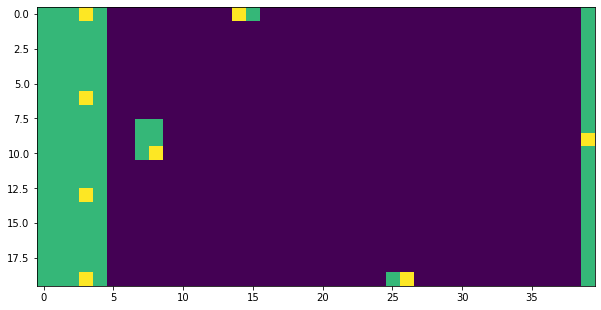

In [196]:
radar_locs = [
    (0, 3),
    (6, 3),
    (13, 3),
    (19, 3),
    (0, 14),
    (10, 8),
    (19, 26),
    (9, 39),
]

plot_locs(terrain, radar_locs)

In [197]:
GRID_SIZE = 50

need cell, unit type, side

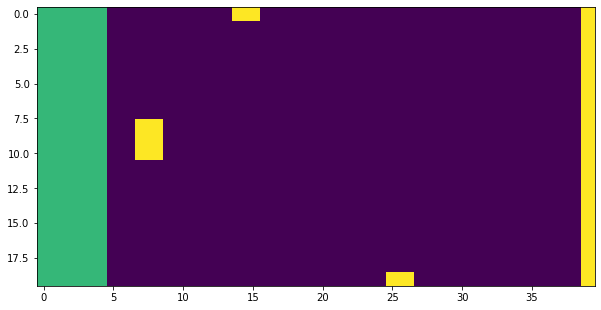

In [198]:
right_civilians = []
for y in range(terrain.shape[0]):
    for x in range(terrain.shape[1]):
        if x > 5 and terrain[y, x] == 1:
            right_civilians.append((y, x))

plot_locs(terrain, right_civilians)

In [199]:
len(right_civilians)

30

In [200]:
# divide the air assets up among the airbases
left_airbase_locs = airbase_locs[:4]
unit_positions = defaultdict(lambda : defaultdict(int))
for unit, count in OOB:
    if unit.domain == AIR:
        for i in range(count):
            unit_positions[left_airbase_locs[i % len(left_airbase_locs)]][unit.name] += 1

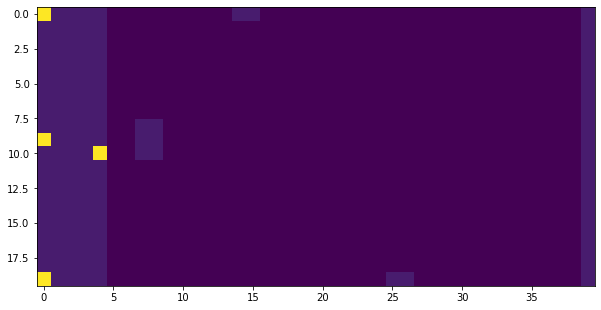

In [201]:
loc_map = np.zeros_like(terrain)

for loc, units in unit_positions.items():
    for unit, count in units.items():
        loc_map[loc] += 0.5 * count
plt.imshow(loc_map + terrain)

In [202]:
def gen_neighbors(coord, max_y, max_x):
    output = []
    for y in [-1, 0, 1]:
        y_pos = coord[0] + y
        if max_y <= y_pos or y_pos < 0:
            continue
        for x in [-1, 0, 1]:
            x_pos = coord[1] + x
            if max_x <= x_pos or x_pos < 0:
                continue
            output.append((y_pos, x_pos))
    return output

gen_neighbors((0, 0), 10, 10), gen_neighbors((9, 9), 10, 10)

([(0, 0), (0, 1), (1, 0), (1, 1)], [(8, 8), (8, 9), (9, 8), (9, 9)])

In [203]:
def distance(coord1, coord2):
    return ((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 )**.5
distance((0, 0), (0, 1))

1.0

In [220]:
missions = {
    (8, 6): (AIR, 10),
    (9, 6): (AIR, 10),
    (10, 6): (AIR, 10),
    (11, 6): (AIR, 10),
}

In [221]:
# flood fill method

visits = defaultdict(lambda : defaultdict(int))
for airbase in airbase_locs[0:1]:
    ab_visits = defaultdict(lambda : defaultdict(int))
#     for loc, units in unit_positions.items():
    for unit, count in unit_positions[airbase].items():
        ab_visits[airbase][unit] = count

    to_visit = gen_neighbors(airbase, *terrain.shape)
    visited = set()
    visited.add(airbase)
    while to_visit:
        current = to_visit.pop(0)
        if current in visited:
            continue
#         print(current)
        visited.add(current)
        
        # find the neighbor that's closest to the airbase, and use that as the starting point
        current_distance = distance(current, airbase)
        closest = None
        closest_distance = current_distance
        to_add = []
        for n in gen_neighbors(current, *terrain.shape):
            if n in visited:
                n_distance = distance(n, airbase)
                if n_distance < closest_distance:
                    closest = n
                    closest_distance = n_distance
            else:
                to_add.append(n)
        
        # now that we know what neighbor to pull from, grab their data and modify it based on the current grid
        base = ab_visits[closest]
        current_units = defaultdict(int)
        still = False
        total = 0
        for unit, count in base.items():
            total += count
            if UNIT_LOOKUP[unit].range >= current_distance * GRID_SIZE:
                current_units[unit] = count
        
        # subtract the units by the mission count
        units_left = max(total - missions.get(current, (AIR, 0))[1], 0)
        
        multiplier = units_left / total
        
        left_units = defaultdict(float)
        for unit, count in current_units.items():
            left_count = multiplier * count
            if left_count > 0:
                left_units[unit] = left_count
                still = True
        if still:
            to_visit.extend(to_add)
            ab_visits[current] = left_units
        print(airbase, current, current_units)
    
    # once all cells are visited, reduce them into the visits map
    for loc, units in ab_visits.items():
        for unit, count in units.items():
            visits[loc][unit] += count

(0, 0) (0, 1) defaultdict(<class 'int'>, {'Bomber': 4, 'Interceptor': 4, 'Fighter': 4, 'MPA': 4, 'Helicopter': 8})
(0, 0) (1, 0) defaultdict(<class 'int'>, {'Bomber': 4, 'Interceptor': 4, 'Fighter': 4, 'MPA': 4, 'Helicopter': 8})
(0, 0) (1, 1) defaultdict(<class 'int'>, {'Bomber': 4, 'Interceptor': 4, 'Fighter': 4, 'MPA': 4, 'Helicopter': 8})
(0, 0) (0, 2) defaultdict(<class 'int'>, {'Bomber': 4.0, 'Interceptor': 4.0, 'Fighter': 4.0, 'MPA': 4.0, 'Helicopter': 8.0})
(0, 0) (1, 2) defaultdict(<class 'int'>, {'Bomber': 4.0, 'Interceptor': 4.0, 'Fighter': 4.0, 'MPA': 4.0, 'Helicopter': 8.0})
(0, 0) (2, 0) defaultdict(<class 'int'>, {'Bomber': 4.0, 'Interceptor': 4.0, 'Fighter': 4.0, 'MPA': 4.0, 'Helicopter': 8.0})
(0, 0) (2, 1) defaultdict(<class 'int'>, {'Bomber': 4.0, 'Interceptor': 4.0, 'Fighter': 4.0, 'MPA': 4.0, 'Helicopter': 8.0})
(0, 0) (2, 2) defaultdict(<class 'int'>, {'Bomber': 4.0, 'Interceptor': 4.0, 'Fighter': 4.0, 'MPA': 4.0, 'Helicopter': 8.0})
(0, 0) (0, 3) defaultdict(<cla

(0, 0) (19, 34) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (0, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (1, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (2, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (3, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (4, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (5, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (6, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (7, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (8, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (9, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (10, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (11, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (12, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (13, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (14, 35) defaultdict(<class 'int'>, {'Bomber': 4.0})
(0, 0) (15, 35) defaultdict(<class 'int'>, {'Bombe

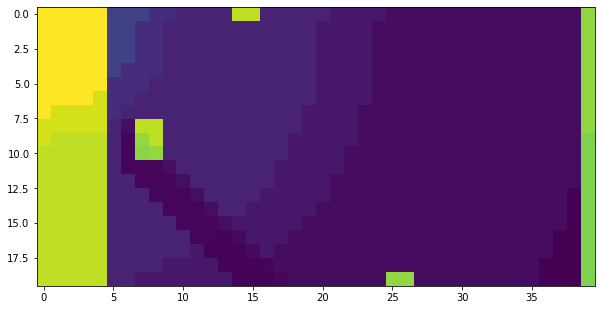

In [222]:
loc_map = np.zeros_like(terrain)

for loc, units in visits.items():
    for unit, count in units.items():
        loc_map[loc[0], loc[1]] += count * 0.01
plt.imshow(loc_map + terrain)

In [183]:
visits[(20,20)]

defaultdict(int, {})